In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm


# Set-up

## Load data

In [2]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Function to load images based on saved order
def load_images_in_order(indices_path, imagenet_dataset):
    indices = np.load(indices_path)
    subset_dataset = Subset(imagenet_dataset, indices)
    data_loader = DataLoader(subset_dataset, batch_size=1)
    return data_loader

# Load the ImageNet dataset
batch_size = 1
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
data_loader = load_images_in_order('imagenet_sample_indices.npy', imagenet_data)


## Load model

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Text(0.5, 1.0, 'Predicted: mountain_bike. True: mountain_bike')

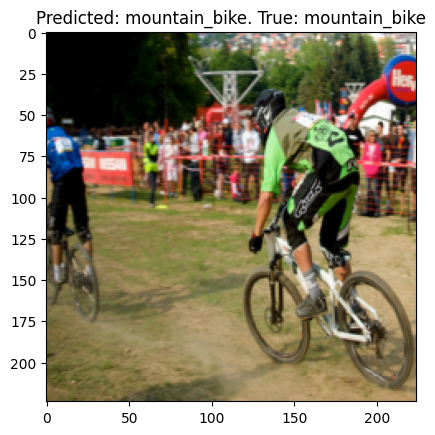

In [3]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M")
processor = CLIPProcessor.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M", do_rescale=False) # Make sure the do_rescale is false for pytorch datasets

images, labels = next(iter(data_loader))

idx = 0

inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
# predicted_class = imagenet_class_names[probs.argmax(dim=1)]
predicted_indices = probs.argmax(dim=1)

plt.imshow(images[idx].permute(1, 2, 0))
plt.title(f"Predicted: {get_class_name(predicted_indices[idx].item())}. True: {get_class_name(labels[idx].item())}")

# Patch/image-level analysis for maximally activating neurons

Look at maximally activating neurons with patch/image as the individual unit.

Loaded from precached activations from 500 randomly sampled ImageNet points.

In [4]:
import pandas as pd
import os

layer_num = 7

save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name = f'mlp_fc1_{layer_num}.npz'

loaded = pd.read_parquet(os.path.join(save_path, file_name))


### Get standard deviation of patch value 

On the neuron level (aggregating across all images and patches for that neuron)**

In [ ]:
# Calculate mean and standard deviation for 'activation_value' grouped by 'neuron_idx'
grouped = loaded.groupby('neuron_idx')['activation_value']
mean_per_neuron = grouped.transform('mean')
std_dev_per_neuron = grouped.transform('std')

# Calculate the z-score (number of standard deviations from the mean)
loaded['activation_value_sds'] = (loaded['activation_value'] - mean_per_neuron) / std_dev_per_neuron

# Replace NaN and infinite values (which can occur if std_dev is zero) with zero
loaded['activation_value_sds'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)


# Sort by z-score
sorted_df = loaded.sort_values(by=['activation_value_sds'], ascending=False)

In [ ]:
sorted_df.head(10).style.background_gradient("coolwarm") 

,batch_idx,class_name,predicted,patch_idx,neuron_idx,activation_value,activation_value_sds
13152974,65,altar,china_cabinet,39,718,2.884666,8.255448
13145806,65,altar,china_cabinet,32,718,2.646834,7.871708
72215878,357,prairie_chicken,quail,194,326,4.269807,7.620927
18999189,94,marmot,guinea_pig,35,917,3.029286,7.596004
28833094,142,flatworm,sea_slug,183,326,4.199399,7.532277
33475910,165,toy_terrier,Chihuahua,186,326,4.195864,7.527826
60105030,297,bustard,bustard,187,326,4.162471,7.485781
13702470,67,binoculars,screwdriver,182,326,4.155445,7.476935
60100934,297,bustard,bustard,183,326,4.132574,7.448139
25343083,125,beer_bottle,puck,124,107,3.059517,7.418534


In [ ]:
sorted_df.tail(10).style.background_gradient("coolwarm")

,batch_idx,class_name,predicted,patch_idx,neuron_idx,activation_value,activation_value_sds
63455872,314,crayfish,hermit_crab,110,640,-2.403679,-5.213074
3662602,18,affenpinscher,Blenheim_spaniel,30,778,-2.295713,-5.273366
80793881,400,crash_helmet,football_helmet,100,281,-2.767182,-5.312747
69618386,345,golf_ball,golf_ball,21,722,-2.265698,-5.334067
75156178,372,dock,lifeboat,110,722,-2.297773,-5.412971
16595142,82,jinrikisha,tricycle,52,198,-2.518162,-5.440258
53209421,263,grille,police_van,151,333,-2.666573,-5.451518
28352710,140,planetarium,planetarium,108,198,-2.534704,-5.478034
23566560,116,miniature_schnauzer,giant_schnauzer,162,224,-2.821187,-5.544946
75157202,372,dock,lifeboat,111,722,-2.461355,-5.815387


In [ ]:
filtered_df = sorted_df[sorted_df['neuron_idx'] == 4]
filtered_df.head(10).style.background_gradient("coolwarm")

,batch_idx,class_name,predicted,patch_idx,neuron_idx,activation_value,activation_value_sds
38591492,191,wok,hot_pot,60,4,2.415503,5.028513
38630404,191,wok,hot_pot,98,4,2.341075,4.939861
31335428,155,eggnog,cup,66,4,2.298464,4.889108
52798468,261,espresso,espresso,144,4,2.279014,4.865940
38584324,191,wok,hot_pot,53,4,2.278162,4.864925
52715524,261,espresso,espresso,63,4,2.235748,4.814406
52796420,261,espresso,espresso,142,4,2.224095,4.800526
52691972,261,espresso,espresso,40,4,2.219584,4.795152
52782084,261,espresso,espresso,128,4,2.124102,4.681423
38567940,191,wok,hot_pot,37,4,2.102017,4.655118


### Return top 5 patches per neuron (based on SD)

In [ ]:
# Ensure 'neuron_idx' is not part of the index
top_patches_per_neuron = loaded.reset_index(drop=True)

# Group by 'neuron_idx', then sort within groups by 'activation_value'
grouped = top_patches_per_neuron.groupby('neuron_idx', group_keys=False).apply(lambda x: x.sort_values('activation_value_sds', ascending=False))

# Get top 5 entries for each neuron
top_5_per_neuron = grouped.groupby('neuron_idx').head(5)

# Selecting the relevant columns
top_5_per_neuron = top_5_per_neuron[['batch_idx', 'neuron_idx', 'patch_idx', 'class_name', 'predicted', 'activation_value', 'activation_value_sds']]


In [ ]:
top_5_per_neuron

# Save dataframe to a CSV file
top_5_per_neuron.to_csv('top_5_per_neuron.csv', index=False)

In [ ]:
top_5_per_neuron.head(10).style.background_gradient("coolwarm")


,batch_idx,neuron_idx,patch_idx,class_name,predicted,activation_value,activation_value_sds
74613760,369,0,172,burrito,head_cabbage,2.022608,4.880951
74596352,369,0,155,burrito,head_cabbage,1.992483,4.829960
74602496,369,0,161,burrito,head_cabbage,1.933013,4.729298
100225024,496,0,164,komondor,Bedlington_terrier,1.844710,4.579832
5616640,27,0,166,horse_cart,Boston_bull,1.814127,4.528065
68855809,341,1,65,trench_coat,military_uniform,1.881213,3.954286
7930881,39,1,62,Irish_water_spaniel,miniature_poodle,1.823647,3.850321
32816129,162,1,133,Windsor_tie,cowboy_hat,1.797661,3.803389
24528897,121,1,117,dowitcher,red-backed_sandpiper,1.788370,3.786611
68871169,341,1,80,trench_coat,military_uniform,1.753309,3.723290


In [ ]:
# Now go back and all the activations for neuron 4
sorted_df[sorted_df['neuron_idx'] == 964].head(15).style.background_gradient("coolwarm")

# Neuron 128 appears to like glasses. Let's print out top 10 patches for this neuron.



,batch_idx,class_name,predicted,patch_idx,neuron_idx,activation_value,activation_value_sds
16882628,83,jean,cowboy_hat,135,964,2.469579,4.743356
16884676,83,jean,cowboy_hat,137,964,2.388666,4.624474
27575236,136,rifle,military_uniform,136,964,2.383067,4.616247
16883652,83,jean,cowboy_hat,136,964,2.367866,4.593912
16911300,83,jean,cowboy_hat,163,964,2.364344,4.588737
23799748,117,sax,sax,192,964,2.334050,4.544228
16896964,83,jean,cowboy_hat,149,964,2.288893,4.477880
93335492,462,barbell,jay,133,964,2.278426,4.462500
15248324,75,orange,groom,115,964,2.270239,4.450471
27543492,136,rifle,military_uniform,105,964,2.264968,4.442727


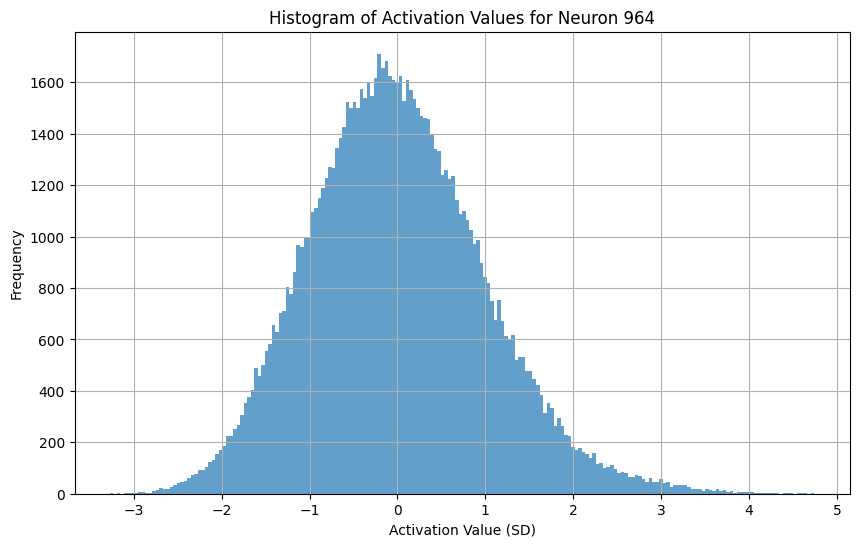

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Should this be in log scale?

neuron_of_interest = 964

# Filter the DataFrame to only include the neuron of interest
filtered_df = loaded[loaded['neuron_idx'] == neuron_of_interest]

# Create a histogram of the activation values
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['activation_value_sds'], bins=200, alpha=0.7)
plt.title(f'Histogram of Activation Values for Neuron {neuron_of_interest}')
plt.xlabel('Activation Value (SD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Do this in log scale? 


In [ ]:
# # Load saved indices
# random_indices = np.load('imagenet_sample_indices.npy')

# # Function to load a specific image
# def load_specific_image(dataset, indices, order):
#     specific_index = indices[order]  # Subtract 1 because list indices start at 0
#     image, label = dataset[specific_index]
#     return image, label

# # Example of loading the 5th image
# image, label = load_specific_image(imagenet_data, random_indices, 479)
# plt.figure()
# plt.imshow(image.permute(1, 2, 0))

### Visualize heatmap for specific image + neuron

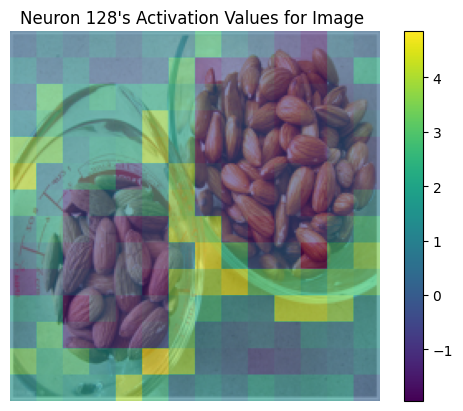

In [ ]:
# import pandas as pd


# def plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224, pixel_num=14):

#     activation_values_array = activation_values_array.reshape(pixel_num, pixel_num)

#     # Create a heatmap overlay
#     heatmap = np.zeros((image_size, image_size))
#     patch_size = image_size // pixel_num

#     for i in range(pixel_num):
#         for j in range(pixel_num):
#             heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values_array[i, j]

#     # Plotting the image with the heatmap overlay
#     fig, ax = plt.subplots()
#     ax.imshow(image.permute(1,2,0))
#     ax.imshow(heatmap, cmap='viridis', alpha=0.6)  # Overlaying the heatmap

#     # Removing axes
#     ax.axis('off')

#     min_activation = activation_values_array.min()
#     max_activation = activation_values_array.max()

#     # Adding colorbar for the heatmap
#     plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_activation, vmax=max_activation)), ax=ax, orientation='vertical')

#     plt.title("Neuron {}'s Activation Values for Image {}".format(specific_neuron_idx, ""))
#     plt.show()


# specific_neuron_idx = 128 
# specific_image_idx = 393 

# image, label = load_specific_image(imagenet_data, random_indices, specific_image_idx)

# filtered_df = loaded[(loaded['batch_idx'] == specific_image_idx) & 
#                              (loaded['neuron_idx'] == specific_neuron_idx)]

# activation_values = filtered_df['activation_value_sds']

# activation_values_array = activation_values.to_numpy()[1:]

# plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)


In [ ]:
def get_image_and_activations_by_id(specific_neuron_idx, specific_image_idx):
    image, label = load_specific_image(imagenet_data, random_indices, specific_image_idx)

    filtered_df = loaded[(loaded['batch_idx'] == specific_image_idx) & 
                                (loaded['neuron_idx'] == specific_neuron_idx)]

    activation_values = filtered_df['activation_value_sds']

    activation_values_array = activation_values.to_numpy()[1:]

    return image, activation_values_array

Top 10 Unique Class Names: ['jean', 'rifle', 'sax', 'barbell', 'orange', 'notebook', 'stethoscope', 'chambered_nautilus', 'beer_bottle', 'German_shepherd', 'miniskirt', 'fire_screen', 'pajama', 'Sealyham_terrier', 'cloak', 'maillot', 'theater_curtain', 'diaper', 'book_jacket', 'lumbermill', 'academic_gown', 'racket', "potter's_wheel", 'yurt', 'lab_coat', 'burrito', 'harmonica', 'poncho', 'vizsla', 'envelope']
Corresponding Activations: [2.469578742980957, 2.3830671310424805, 2.334050178527832, 2.278425931930542, 2.2702388763427734, 2.251925468444824, 2.1499314308166504, 2.1440813541412354, 2.1411657333374023, 2.0266542434692383, 2.0071115493774414, 1.9919623136520386, 1.9897714853286743, 1.9851219654083252, 1.9825971126556396, 1.9750585556030273, 1.9619157314300537, 1.9575176239013672, 1.9451156854629517, 1.9352984428405762, 1.910401701927185, 1.8723050355911255, 1.861104965209961, 1.8423473834991455, 1.8353710174560547, 1.8321735858917236, 1.8301751613616943, 1.8231850862503052, 1.816

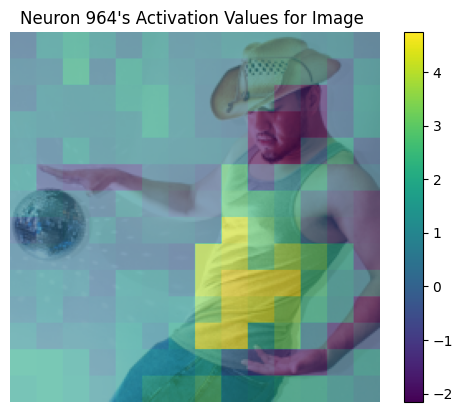

In [ ]:
# Get top 10 class names, no duplicates
specific_neuron_idx = 964

unique_top_entries = sorted_df[sorted_df['neuron_idx'] == specific_neuron_idx].drop_duplicates(subset='class_name').head(30)

# Extracting class names and activation values
unique_top_class_names = unique_top_entries['class_name'].tolist()
unique_top_activations = unique_top_entries['activation_value'].tolist()
unique_top_batch_idx = unique_top_entries['batch_idx'].tolist()

# Lists are ready to use
print("Top 10 Unique Class Names:", unique_top_class_names)
print("Corresponding Activations:", unique_top_activations)
print("Corresponding Batch Indices:", unique_top_batch_idx)


# Now plot

for i, batch_idx in enumerate(unique_top_batch_idx):
    image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, batch_idx)
    plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)
    print("Class Name:", unique_top_class_names[i])
    print("Activation Value:", unique_top_activations[i])
    print("Batch Index:", unique_top_batch_idx[i])
    print("")
# image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, unique_top_batch_idx[0])
# plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)